In [1]:
!pip -q install tensorly

     |████████████████████████████████| 163kB 4.3MB/s 
     |████████████████████████████████| 163kB 29.2MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
%matplotlib inline
import csv
import os
import sys
import pickle
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
# Imported Libraries
import time
import gc
# Classifier Libraries
import collections
import warnings
import torch
import tensorly as tl
tl.set_backend('pytorch')
warnings.filterwarnings("ignore")
import statsmodels.api as sm
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, LSTM,MaxPooling2D,Conv2D,MaxPooling3D,Conv3D, Flatten,TimeDistributed
from keras.models import Sequential  
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso, LogisticRegression, ElasticNet
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor, GradientBoostingRegressor
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, confusion_matrix
from tensorly import unfold as tl_unfold
from tensorly.decomposition import parafac
from tensorly.regression.tucker_regression import TuckerRegressor


In [4]:
root_folder="/content/drive/MyDrive/freelance_Ahamed"
def generate_stats(root_folder):
    green_alarms =["A1","A17","A19","A23","A25","A29","A35","A315"]
    files=os.listdir(root_folder)
    lst=[]
    for f in files:
        if os.path.isdir(os.path.join(root_folder,f)):
            pwd = os.path.join(root_folder,f)
            y = pd.read_csv(os.path.join(pwd,"y.csv"),header=None)
            labels=pd.read_csv(os.path.join(pwd,"classes.csv"),header=None)
            alrm='folder:'+f+' alarm'
            labels.columns=[alrm]
            fd = pd.DataFrame(np.zeros((len(labels),1)),columns=['count'])
            dfs = pd.concat([labels,fd], axis=1)
            for i,row in dfs.iterrows():
                cnt=np.sum(y==i)
                dfs.loc[i,'count']=cnt[0]
            lst.append(dfs)
    new_lst=[]
    for df in lst:
        s=pd.DataFrame(np.zeros(df.shape[0]),columns=['green_alarm'])
        s=pd.concat([df,s],axis=1)
        for i,row in df.iterrows():
            if row.iloc[0] in green_alarms:
                s.loc[i,'green_alarm']='green'
            else:
                s.loc[i,'green_alarm']='irrelevent'
        new_lst.append(s)
    return new_lst

In [5]:
new_lst = generate_stats(root_folder)

In [6]:

new_lst

[  folder:13 alarm   count green_alarm
 0             A33   302.0  irrelevent
 1            A502    11.0  irrelevent
 2             A69   302.0  irrelevent
 3          Normal  6150.0  irrelevent]

In [7]:



def load_data(root_folder):
    try:
        x_train = np.load(os.path.join(root_folder,'x_train_vec.npy'))
        x_test = np.load(os.path.join(root_folder,'x_test_vec.npy'))
        y_train = np.load(os.path.join(root_folder,'y_train_vec.npy'))
        y_test = np.load(os.path.join(root_folder,'y_test_vec.npy'))
    except:
        csv_to_numpy(root_folder,total_rows = 500)
        train_test_split_data(root_folder)
        x_train = np.load(os.path.join(root_folder,'x_train_vec.npy'))
        x_test = np.load(os.path.join(root_folder,'x_test_vec.npy'))
        y_train = np.load(os.path.join(root_folder,'y_train_vec.npy'))
        y_test = np.load(os.path.join(root_folder,'y_test_vec.npy'))
    return x_train,y_train,x_test,y_test

In [8]:
 
def break_csv(source_filepath, dest_path, result_filename_prefix, row_limit):
    """
    Break a source CSV into multiple CSVs of equal numbers of records,
    except the last file.
    The initial file's header row will be included as a header row in each split
    file.
    Split files follow a zero-index sequential naming convention like so:
        `{result_filename_prefix}_0.csv`
    :param source_filepath {str}:
        File name (including full path) for the file to be split.
    :param dest_path {str}:
        Full path to the directory where the split files should be saved.
    :param result_filename_prefix {str}:
        File name to be used for the generated files.
    :param row_limit {int}:
        Number of rows per file (header row is excluded from the row count).
    :return {NoneType}:
    """
    if row_limit <= 0:
        raise Exception('row_limit must be > 0')
    if not os.path.exists(dest_path):
        os.mkdir(dest_path)
    with open(source_filepath, 'r') as source:
        reader = csv.reader(source)
        headers = next(reader)
        file_number = 0
        records_exist = True
        while records_exist:
            i = 0
            target_filename = f'{result_filename_prefix}_{file_number}.csv'
            target_filepath = os.path.join(dest_path, target_filename)
            with open(target_filepath, 'w') as target:
                writer = csv.writer(target)
                while i < row_limit:
                    if i == 0:
                        writer.writerow(headers)
                    try:
                        writer.writerow(next(reader))
                        i += 1
                    except:
                        records_exist = False
                        break
            if i == 0:
                os.remove(target_filepath)
            file_number += 1

In [9]:
def csv_to_numpy(root_dir,total_rows = 500):
    source = os.path.join(root_dir,"X_range_local.csv")
    y_path = os.path.join(root_dir,"y.csv")
    try: 
        df = pd.read_csv(source)
        arr = np.array(df)
        arr_y = pd.read_csv(y_path)
    except:
        dest_x = os.path.join(root_dir,"new")
        filname_prefix = "X_range_local"
        break_csv(source, dest_x, filname_prefix, total_rows)
        os.remove(os.path.join(dest_y,"y_29.csv"))
        source_y = os.path.join(root_dir,"y.csv")
        dest_y = os.path.join(root_dir,"newest_y")
        filname_prefix_y = "y"
        break_csv(source_y, dest_y, filname_prefix_y, total_rows)
        os.remove(os.path.join(dest_x,"X_range_local_29.csv")) 

        pwd = os.path.join(root_dir,dest_x)
        filenames = os.listdir(pwd)
        np_dest_x =  os.path.join(root_dir,"X_range_np")
        print("="*29)
        if os.listdir(np_dest_x) ==[]:
            for f in filenames:
                df_mini = pd.read_csv(os.path.join(pwd,f))
                new_arr = np.array(df_mini)
                if not os.path.exists(np_dest_x):
                    os.mkdir(np_dest_x)
                np_path= f.split('_')[-1]
                np_path= os.path.join(np_dest_x,np_path.split('.')[0]+".npy")
                np.save(np_path,new_arr)
                print("=",end='')
        pwd = os.path.join(root_dir,dest_y)
        filenames = os.listdir(pwd)
        np_dest =  os.path.join(root_dir,"y_np")
        print("="*29)
        if os.listdir(np_dest) ==[]:
            for f in filenames:
                df_mini = pd.read_csv(os.path.join(pwd,f))
                new_arr = np.array(df_mini)
                if not os.path.exists(np_dest):
                    os.mkdir(np_dest)
                np_path= f.split('_')[-1]
                np_path= os.path.join(np_dest,np_path.split('.')[0]+".npy")
                np.save(np_path,new_arr)
                print("=",end='')
        pwd =  np_dest_x
        filenames = os.listdir(pwd)
        dirlist = sorted_alphanumeric(filenames)
        dirlist.reverse()
        arr = np.array([])
        print("="*20)

        for f in dirlist[9:]:
            path_new=os.path.join(os.path.join(pwd,f))
            s=np.load(path_new)
            if len(arr.shape) < 2:
                arr = s
            elif arr.shape[0]==10000:
                break
            else:
                arr=np.vstack([s,arr])
            del s
            gc.collect()
            print("=",end='')
        pwd = np_dest
        filenames = os.listdir(pwd)
        dirlist = sorted_alphanumeric(filenames)
        dirlist.reverse()
        arr_y = np.array([])
        print("="*20)
        for f in dirlist[9:]:
            path_new=os.path.join(os.path.join(pwd,f))
            s=np.load(path_new)
            if arr_y.shape == (0,):
                arr_y = s
            elif arr_y.shape[0]==10000:
                break
            else:
                arr_y=np.vstack([s,arr_y])
            del s
            gc.collect()
            print("=",end='')
    np_save_path_x = os.path.join(root_dir,'X_range_local_10k.npy')
    np.save(np_save_path_x,arr)
    np_save_path_y = os.path.join(root_dir,'y2_10k.npy')
    np.save(np_save_path_y,arr_y)
    print(np_save_path_x,np_save_path_y)


In [10]:
import re
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)


In [11]:
def train_test_split_data(root_dir):
    arr = np.load(os.path.join(root_dir,'X_range_local_10k.npy'))
    arr_y = np.load(os.path.join(root_dir,'y2_10k.npy'))
    time =  pd.read_csv(os.path.join(root_dir,"times_id.csv"),header=None)
    feature =  pd.read_csv(os.path.join(root_dir,"features_id.csv"),header=None)
    time = np.max(np.asarray(time))
    feature = np.max(np.asarray(feature))
    arr = arr.reshape(arr.shape[0],feature,time)
    x_train, x_test, y_train, y_test = train_test_split(arr, arr_y, test_size=0.2, random_state=42, shuffle = False) #Balaji Edit
    np_path=root_dir
    np.save(os.path.join(np_path,'x_train_vec.npy'),x_train)
    np.save(os.path.join(np_path,'x_test_vec.npy'),x_test)
    np.save(os.path.join(np_path,'y_train_vec.npy'),y_train)
    np.save(os.path.join(np_path,'y_test_vec.npy'),y_test)


PLotiing 

In [12]:
import matplotlib.pyplot as plt # Impot the relevant module
def plot_x(pred, original, alarm):
    pred = torch.tensor(pred,device='cpu')
    original = torch.tensor(original,device='cpu')

    # print('Predicted And Original Values:\n',torch.hstack([original.reshape(original.shape[0],1),pred.reshape(pred.shape[0],1)]))
    fig, ax = plt.subplots(figsize=(18,6)) # Create the figure and axes object    
    x = [*range(0,pred.shape[0],1)]
    x = torch.tensor(x,device='cpu')

    # Plot the first x and y axes:
    ax.plot(x, pred, 'o-') 
    ax.plot(x ,original, 'r')
    ax.set_xlabel('Samples')
    ax.set_ylabel('Time till Alarm')
    fig.suptitle(alarm)
    ax.legend(['Predictions','Original'])
    fig.show()
    plt.show()
    plt.pause(0.0001)                       #add this it will be OK.
    fig.savefig(alarm+'.jpg')


In [13]:
def plot_y(pred,original):
    pred = torch.tensor(pred,device='cpu')
    original = torch.tensor(original,device='cpu')
    plt.figure(figsize=(18,6))
    plt.scatter(original, pred, c='crimson')
    print('Predicted And Original Values:\n',torch.hstack([original,pred]))
    p1 = max(max(pred), max(original))
    p2 = min(min(pred), min(original))
    print(p1,p2)
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('True Values', fontsize=15)
    plt.ylabel('Predictions', fontsize=15)
    plt.show()

In [14]:
# Returns only the alarm samples in the dataset
def select_alarms(X,Y,alarm_select=None):
    new_X=[]
    new_Y=[]
    if alarm_select is not None:
        X=X[(Y.T!=np.max(Y))[0]]
        Y=Y[(Y.T!=np.max(Y))[0]].T
        if alarm_select in set(np.ravel(Y)):
            new_X.append(X[(Y==alarm_select)[0]])
            new_Y.append(Y[0][(Y==alarm_select)[0]])
        return np.array(new_X), np.array(new_Y)

    X=X[(Y.T!=np.max(Y))[0]]
    Y=Y[(Y.T!=np.max(Y))[0]].T
    for i in set(np.ravel(Y)):
        new_X.append(X[(Y==i)[0]])
        new_Y.append(Y[0][(Y==i)[0]])
    return np.array(new_X), np.array(new_Y)

Tensor Regression

In [15]:
def train_test_divide_tensor(x,y,test_size=0.2):
    y=np.array(y,dtype=np.double)
    y=torch.tensor(y)
    # Duplicating data for small number of samples
    if x.shape[0]<7:
        x = torch.vstack([x,x])
        y = torch.vstack([y,y])
    if x.shape[0]<7:
        x = torch.vstack([x,x])
        y = torch.vstack([y,y])
    if x.shape[0]<7:
        x = torch.vstack([x,x])
        y = torch.vstack([y,y])
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=test_size,shuffle=False, random_state=22) # Why was shuffle True here? Balaji Edits
    return x_train,x_test,y_train,y_test

In [16]:
# Takes n-dimension array and hankelizes it by adding a lag dimension
def hankelize(X, lag=5):
    samples = X.shape[0]
    time_samples=X.shape[-1]//lag
    x_hankelized = np.zeros((samples,X.shape[1],X.shape[2],time_samples))
    step_size = X.shape[2]//time_samples
    for i in range(samples):
        for j in range(X.shape[1]):
            x_t = X[i,j,:]
            x = np.zeros((time_samples,X.shape[2]))
            for k in range(time_samples):
                x_hankelized[i,j,:,k]=np.hstack([x_t[k*step_size:],np.zeros((k*step_size))])  
    return torch.tensor(x_hankelized,device='cuda')

In [17]:
# Divide dataset into windows and hankelize it
def divide_into_windows_and_hankle(X, tg=6, window=24, lag=5, detail=1):
    if detail:
        print("\nDividing the X data into windows, \nOriginal shape (features, time):",X.shape)
    sample_time = 5
    X=np.mean(X.reshape(X.shape[0], X.shape[1]//tg, tg), axis=2)
    if detail:
        print("Time granuality by taking average of every",str(tg*sample_time),"seconds, \nNew shape (features, time):",X.shape)
    Y= np.array([y for y in range((720-tg*window)*sample_time,-1,-sample_time*tg*window)]).reshape(-1,1)
    X=X.reshape(X.shape[0],window,X.shape[1]//window)
    if detail:
        print("Dividing the data into windows of",str(window),"samples each, total windows:",X.shape[2])
        print("New shape (features, time, windows):",X.shape)
    X=X.transpose([2,0,1])
    if detail:
        print("Transposing the dimensions for tensor regression, \nNew shape (windows, features, time):", X.shape)
    x_hankelized = hankelize(X, lag=lag)
    if detail:
        print("Hankelizing with lag in samples:",lag,"\nNew shape (windows, features, time, lag):",x_hankelized.cpu().numpy().shape)
    if detail:
        print("New shape of X after applying time granuality and window split,\
         \nNew shape (windows, features, time, lag):",x_hankelized.cpu().numpy().shape)
        print("Shape of Y created using X:",Y.shape)
    return torch.tensor(x_hankelized,device='cuda'),torch.tensor(Y,device='cuda')

In [18]:
# Create a dataset for tensor regression using helper functions
def divide_and_create_tr_datasets(xe,ye,tg=5, window=30, lag=5,detail=1):
    alarms_dict={}
    for x,y in zip(xe,ye):
        new_x=[]
        new_y=[]
        if x.shape[0]==1:
            x=x[0]
            new_x,new_y=divide_into_windows_and_hankle(x, tg=tg, window=window, lag=lag, detail=detail)
        else:
            for xi,yi in zip(x,y):
                if np.shape(new_x)[0]==0:
                    new_x,new_y=divide_into_windows_and_hankle(xi, tg=tg, window=window, lag=lag, detail=detail)
                else:
                    new_x=torch.vstack([new_x,divide_into_windows_and_hankle(xi, tg=tg, window=window, lag=lag, detail=detail)[0]])
                    new_y=torch.vstack([new_y,divide_into_windows_and_hankle(xi, tg=tg, window=window, lag=lag, detail=detail)[1]])
        alarms_dict.update({y[0]:(new_x,new_y)})
    return alarms_dict


In [19]:
# Select alarms from main dataset, divide into windows and hankelize it
def preprocess_hanklize_tensors(X,y,window=30,tg=10,lag=30, detail=1):
    X,y=select_alarms(X,y)
    alarm_ds=divide_and_create_tr_datasets(X,y,tg=tg, window=window, lag=lag, detail=detail)
    return alarm_ds

In [20]:
 def save_model(root_dir,filename,model,model_file):
    models_dir =os.path.join(root_dir,'models')
    if not os.path.exists(os.path.join(root_dir,'models')):
        os.mkdir(models_dir)
    if model=='reg':
        filename = filename +'.sav'
        pickle.dump(model_file, open(os.path.join(models_dir,filename), 'wb'))
    if model=='nn' or model =='NN':
        filename = filename +'.h5'
        model_file.save(os.path.join(models_dir,filename)) 


In [21]:
def train_cp_regressor(x_train,y_train,cp_components=5):
    cpregressor=CPRegressor(cp_components,n_iter_max=300,tol=1e-09,reg_W=1)
    cpregressor.fit(x_train,y_train)
    pred_cv=cpregressor.predict(x_train)
    mae=mean_absolute_error(y_train.cpu().numpy(),pred_cv.cpu().numpy())
    return cpregressor, mae
    

In [22]:
def train_tucker_regressor(x_train,y_train, rank=5):
    tucker = TuckerRegressor(weight_ranks=[rank, rank, rank], n_iter_max=300, tol=1e-09, reg_W=1, verbose=0)
    tucker.fit(x_train,y_train)
    pred_cv=tucker.predict(x_train)
    mae=mean_absolute_error(y_train.cpu().numpy(),pred_cv.cpu().numpy())
    return tucker, mae
    

Tucker Regression

In [23]:
from tensorly.regression.cp_regression import CPRegressor
import tensorly as tl
import torch
tl.set_backend('pytorch')
from sklearn.metrics import mean_absolute_error

# Perform tensor regression using CP regression for all alarms in the dataset directory
def hankle_and_train_tensor_regression(root_dir,window=[30],tg=[5],lag=[30],cp_components=5,model='reg'):
    x_train,y_train,x_test,y_test = load_data(root_dir)
    dataset_name = os.path.split(root_dir)[-1]
    X=np.vstack([x_train,x_test])
    Y=np.vstack([y_train,y_test])
    cv=5
    column_list = ['Alarm','Time Granuality','Window Size','Lag','Train MAE','Test MAE','Regression Samples']
    mae_scores = pd.DataFrame(columns=column_list)
    iters=0
    for w in window:
        for t in tg:
            for l in lag:
                w1,t1=int((w*60)//5), t//5 
                if 720//t1 % w1 !=0:
                    continue   
                data_folder = os.path.join(root_dir,'tensor_data_folder')
                if not os.path.exists(data_folder):
                      os.mkdir(data_folder)
                path = data_folder+'/'+dataset_name+'_'+'ws:'+str(w)+'_'+'tg:'+str(t)+'_'+'lag:'+str(l)+'.pickle'
                try:
                    with open(path, 'rb') as ds:
                        alarms_dataset = pickle.load(ds)
                    print('[Loading preprocessed dataset]')

                except:
                    alarms_dataset=preprocess_hanklize_tensors(X,Y, window=w1,tg=t1,lag=l)
                    #with open(path, 'wb') as ds:
                        #pickle.dump(alarms_dataset, ds)
                for i,ds in alarms_dataset.items():
                    # Train Test Split
                    x,y=ds
                    if iters ==0:
                      print(y)
                    do_train=True

                    # Alarm Names
                    alarm_name = pd.read_csv(root_dir+'/classes.csv' ,header=None)[0].iloc[i]
                    exp_name_ =alarm_name+'_'+'ws:'+str(w)+'_'+'tg:'+str(t)+'_'+'lag:'+str(l)
                    exp_name = exp_name_+'_'+'Experiment:'+str(iters)
                    print(x.shape[0])
                    if not x.shape[0]>=200:
                        print("Skipping for ",alarm_name,"\nLess than 200 samples for ",exp_name_)
                        continue

                    x_train,x_test,y_train,y_test=train_test_divide_tensor(x,y.cpu())
                    x_train,x_test = torch.tensor(x_train,device='cuda'),torch.tensor(x_test,device='cuda')
                    y_train,y_test = torch.tensor(y_train,device='cuda'),torch.tensor(y_test,device='cuda')

                    filename = "Tensor_regression_"+exp_name_+'.sav'
                    filename_nn = "Tensor_regression_"+exp_name_+'.h5'
                    model_path=os.path.join(root_dir,"models")
                    if not os.path.exists(model_path):
                        os.mkdir(model_path)
                    if filename in os.listdir(model_path):
                        try:
                            cpregressor = pickle.load(open(os.path.join(model_path,filename), 'rb'))
                            do_train = False
                            train_mae = mean_absolute_error(cpregressor.predict(x_train),y_train)
                            print("[Using pretrained model]")
                        except Exception as e:
                            print(e)
                            continue
                    elif filename_nn in os.listdir(model_path):
                        try:
                            lstm = tf.keras.models.load_model(os.path.join(model_path,filename_nn))
                            train_mae = mean_absolute_error(lstm.predict(x_train),y_train)
                            do_train = False
                            print("[Using pretrained model]")
                        except:
                            print(e)
                            continue
                    # Training
                    if model == 'reg':
                        if do_train:
                            print(x_train.element_size() * x_train.nelement())
                            cpregressor, train_mae = train_cp_regressor(x_train,y_train,cp_components=cp_components)
                        pred=cpregressor.predict(x_test)
                        model_file = cpregressor
                    if model == 'nn' or model == 'NN':
                        if do_train:
                            lstm, train_mae = train_CNN(x_train,y_train)
                        x_test = torch.transpose(tl.tensor(x_test), 1, 2)
                        pred = lstm.predict(torch.unsqueeze(x_test,dim=3).cpu().numpy())
                        model_file = lstm
                        
                    # Round large values to 3600 and negative to 0
                    pred=pred.cpu()
                    pred = np.maximum(pred,0)
                    pred[pred>3600]=3600
                    t_pred=model_file.predict(x_train)
                    t_pred=t_pred.cpu()
                    t_pred = np.maximum(t_pred,0)
                    t_pred[t_pred>3600]=3600

                    # Plotting
                    if not os.path.exists(os.path.join(root_dir,"plots")):
                       os.mkdir(os.path.join(root_dir,"plots"))
                    plot_x(pred.ravel(),y_test.cpu().numpy().ravel(),os.path.join(root_dir,"plots",exp_name))
                    plot_x(t_pred.ravel(),y_train.cpu().numpy().ravel(),os.path.join(root_dir,"plots","train_plot_"+exp_name))

                    # Calculating MAE and saving results
                    mae = mean_absolute_error(y_test.cpu().numpy(),pred.numpy())
                    data=[alarm_name,t,w,l,np.round(train_mae,4),np.round(mae,4),x.shape[0]]
                    mae_score = pd.DataFrame([data],columns=column_list)
                    mae_scores=mae_scores.append(mae_score, ignore_index=True)
                    print("Experiment: ",iters)
                    
                    # Saving the models
                    save_model(root_dir,filename,model,model_file)
                    iters+=1

    csv_path = os.path.join(root_dir,dataset_name+'_tensor_'+model+'_mae_scores.csv')
    mae_scores.sort_values('Alarm')
    mae_scores.to_csv(csv_path)
    print('Done')
    return csv_path

CNN 

In [24]:
#Balaji Edits - Added a dropout layer to prevent over fitting
def train_CNN(x_train,y_train, x_test, y_test):
    #x_train = torch.transpose(tl.tensor(x_train), 1, 2)
    #x_train = torch.unsqueeze(x_train,dim=3)
    print(x_train.shape)
    CNN_model = Sequential()
    CNN_model.add(Conv2D(64, (3,3), activation='elu', padding='same', input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]), data_format='channels_first'))
    CNN_model.add(MaxPooling2D((3,3), padding='same'))
    CNN_model.add(Conv2D(128, (3,3), activation='elu', padding='same'))
    CNN_model.add(MaxPooling2D((3,3), padding='same'))
    CNN_model.add(Conv2D(256, (3,3), activation='elu', padding='same'))
    CNN_model.add(Dropout(0.7))
    CNN_model.add(Flatten())
    CNN_model.add(Dense(150, activation='elu'))
    CNN_model.add(Dropout(0.3))
    CNN_model.add(Dense(1))
    CNN_model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])
    history=CNN_model.fit(x_train.cpu().numpy(), y_train.cpu().numpy(), epochs=30, verbose=1, validation_data = (x_test.cpu().numpy(), y_test.cpu().numpy()))
    pd.DataFrame(history.history)[['mae', 'val_mae']].plot(marker='o')
    return CNN_model

In [31]:
def train_LSTM(x_train, y_train, x_test, y_test):
    x_train = torch.transpose(x_train, 1, 2)
    x_test = torch.transpose(x_test, 1, 2)
    print(x_train.shape)
    LSTM_model = Sequential()
    LSTM_model.add(TimeDistributed(Flatten(input_shape=(x_train.shape[2],x_train.shape[3]))))
    LSTM_model.add(LSTM(128, activation = "relu"))
    #LSTM_model.add(Dense(100, activation = "relu"))
    LSTM_model.add(Dense(1, activation = "relu"))
    LSTM_model.compile(optimizer = 'Adamax', loss = "mean_absolute_error", metrics = ['mae'])
    history = LSTM_model.fit(x_train.cpu().numpy(), y_train.cpu().numpy(), batch_size = 15, epochs = 30, verbose = 1, validation_data = (x_test.cpu().numpy(), y_test.cpu().numpy()))
    print(LSTM_model.summary())
    pd.DataFrame(history.history)[['mae', 'val_mae']].plot(marker = 'o')
    return LSTM_model

In [32]:
# New Experiment = Balaji Edits - Added a dropout layer to prevent over fitting
def train_CNN(x_train,y_train, x_test, y_test):
    #x_train = torch.transpose(tl.tensor(x_train), 1, 2)
    #x_train = torch.unsqueeze(x_train,dim=3)
    print(x_train.shape)
    CNN_model = Sequential()
    CNN_model.add(Conv2D(64, (3,3), activation='elu', padding='same', input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]), data_format='channels_first'))
    CNN_model.add(MaxPooling2D((3,3), padding='same'))
    CNN_model.add(Conv2D(128, (3,3), activation='elu', padding='same'))
    CNN_model.add(MaxPooling2D((3,3), padding='same'))
    CNN_model.add(Conv2D(256, (3,3), activation='elu', padding='same'))
    #CNN_model.add(Dropout(0.7))
    CNN_model.add(Flatten())
    CNN_model.add(Dense(150, activation='elu'))
    CNN_model.add(Dropout(0.5))
    CNN_model.add(Dense(1))
    CNN_model.compile(optimizer='adamax', loss='mean_squared_error', metrics=['mae'])
    history=CNN_model.fit(x_train.cpu().numpy(), y_train.cpu().numpy(), epochs=30, verbose=1, validation_data = (x_test.cpu().numpy(), y_test.cpu().numpy()))
    pd.DataFrame(history.history)[['mae', 'val_mae']].plot(marker='o')
    return CNN_model

In [42]:
from tensorly.regression.cp_regression import CPRegressor
import tensorly as tl
import torch
tl.set_backend('pytorch')
from sklearn.metrics import mean_absolute_error

# Perform tensor regression using CP regression for all alarms in the dataset directory
def hankle_and_train_tensor_regression(root_dir,window=[30],tg=[5],lag=[30],cp_components=5,model='reg'):
    x_train,y_train,x_test,y_test = load_data(root_dir)
    dataset_name = os.path.split(root_dir)[-1]
    X=np.vstack([x_train,x_test])
    Y=np.vstack([y_train,y_test])
    cv=5
    column_list = ['Alarm','Time Granuality','Window Size','Lag','Train MAE','Test MAE','Regression Samples']
    mae_scores = pd.DataFrame(columns=column_list)
    iters=0
    for w in window:
        for t in tg:
            for l in lag:
                w1,t1=int((w*60)//5), t//5 
                if 720//t1 % w1 !=0:
                    continue   
                data_folder = os.path.join(root_dir,'tensor_data_folder')
                if not os.path.exists(data_folder):
                      os.mkdir(data_folder)
                path = data_folder+'/'+dataset_name+'_'+'ws:'+str(w)+'_'+'tg:'+str(t)+'_'+'lag:'+str(l)+'.pickle'
                try:
                    with open(path, 'rb') as ds:
                        alarms_dataset = pickle.load(ds)
                    print('[Loading preprocessed dataset]')

                except:
                    alarms_dataset=preprocess_hanklize_tensors(X,Y, window=w1,tg=t1,lag=l, detail=0)
                    #with open(path, 'wb') as ds:
                        #pickle.dump(alarms_dataset, ds)
                for i,ds in alarms_dataset.items():
                    # Train Test Split
                    x,y=ds
                    if iters ==0:
                      print(y)
                    do_train=True

                    # Alarm Names
                    alarm_name = pd.read_csv(root_dir+'/classes.csv' ,header=None)[0].iloc[i]
                    exp_name_ =alarm_name+'_'+'ws:'+str(w)+'_'+'tg:'+str(t)+'_'+'lag:'+str(l)
                    exp_name = exp_name_+'_'+'Experiment:'+str(iters)
                    print(x.shape[0])
                    if not x.shape[0]>=200:
                        print("Skipping for ",alarm_name,"\nLess than 200 samples for ",exp_name_)
                        continue

                    x_train,x_test,y_train,y_test=train_test_divide_tensor(x,y.cpu())
                    x_train,x_test = torch.tensor(x_train,device='cuda'),torch.tensor(x_test,device='cuda')
                    y_train,y_test = torch.tensor(y_train,device='cuda'),torch.tensor(y_test,device='cuda')

                    filename = "Tensor_regression_"+exp_name_+'.sav'
                    filename_nn = "Tensor_regression_"+exp_name_+'.h5'
                    model_path=os.path.join(root_dir,"models")
                    if not os.path.exists(model_path):
                        os.mkdir(model_path)
                    if filename in os.listdir(model_path):
                        try:
                            cpregressor = pickle.load(open(os.path.join(model_path,filename), 'rb'))
                            do_train = False
                            train_mae = mean_absolute_error(cpregressor.predict(x_train),y_train)
                            print("[Using pretrained model]")
                        except Exception as e:
                            print(e)
                            continue
                    elif filename_nn in os.listdir(model_path):
                        try:
                            lstm = tf.keras.models.load_model(os.path.join(model_path,filename_nn))
                            train_mae = mean_absolute_error(lstm.predict(x_train),y_train)
                            do_train = False
                            print("[Using pretrained model]")
                        except:
                            print(e)
                            continue
                    # Training
                    if model == 'reg':
                        if do_train:
                            print(x_train.element_size() * x_train.nelement())
                            cpregressor, train_mae = train_tucker_regressor(x_train.cpu().numpy(),y_train.cpu().numpy(),rank=cp_components)
                        pred=cpregressor.predict(x_test.cpu().numpy())
                        model_file = cpregressor
                    if model == 'nn' or model == 'NN':
                        print("alarm", i)
                        if do_train:
                            lstm = train_LSTM(x_train,y_train, x_test, y_test)
                        x_test = torch.transpose(tl.tensor(x_test), 1, 2)
                        x_train = torch.transpose(tl.tensor(x_train), 1, 2)
                        print("got here!")
                        pred = lstm.predict(x_test.cpu().numpy())
                        print("done!!!")
                        model_file = lstm
                        
                    # Round large values to 3600 and negative to 0
                    #pred=pred.cpu()
                    pred = np.maximum(pred,0)
                    pred[pred>3600]=3600
                    
                    t_pred=model_file.predict(x_train.cpu().numpy())
                    t_pred = np.maximum(t_pred,0)
                    t_pred[t_pred>3600]=3600
                    
                    # Plotting
                    if not os.path.exists(os.path.join(root_dir,"plots")):
                       os.mkdir(os.path.join(root_dir,"plots"))
                    plot_x(pred.ravel(),y_test.cpu().numpy().ravel(),os.path.join(root_dir,"plots",exp_name))
                    plot_x(t_pred.ravel(),y_train.cpu().numpy().ravel(),os.path.join(root_dir,"plots","train_plot_"+exp_name))

                    # Calculating MAE and saving results
                    mae = mean_absolute_error(y_test.cpu().numpy(),pred)
                    train_mae = mean_absolute_error(t_pred, y_train.cpu().numpy())
                    data=[alarm_name,t,w,l,np.round(train_mae,4),np.round(mae,4),x.shape[0]]
                    mae_score = pd.DataFrame([data],columns=column_list)
                    mae_scores=mae_scores.append(mae_score, ignore_index=True)
                    print("Experiment: ",iters)
                    
                    # Saving the models
                     #save_model(root_dir,filename,model,model_file)
                    iters+=1

    csv_path = os.path.join(root_dir,dataset_name+'_tensor_'+model+'_mae_scores.csv')
    mae_scores.sort_values('Alarm')
    mae_scores.to_csv(csv_path)
    print('Done')
    return csv_path

In [43]:
root_dir="/content/drive/MyDrive/freelance_Ahamed/13"

tensor([[3480],
        [3360],
        [3240],
        ...,
        [ 240],
        [ 120],
        [   0]], device='cuda:0')
9030
alarm 0
torch.Size([7224, 12, 28, 3])
Epoch 1/10
482/482 [==============================] - 18s 34ms/step - loss: 1057.5188 - mae: 1057.5188 - val_loss: 954.6014 - val_mae: 954.6014
Epoch 2/10
482/482 [==============================] - 16s 33ms/step - loss: 960.5234 - mae: 960.5234 - val_loss: 952.3015 - val_mae: 952.3015
Epoch 3/10
482/482 [==============================] - 16s 33ms/step - loss: 956.2273 - mae: 956.2273 - val_loss: 940.7651 - val_mae: 940.7651
Epoch 4/10
482/482 [==============================] - 16s 33ms/step - loss: 936.8811 - mae: 936.8811 - val_loss: 945.2069 - val_mae: 945.2069
Epoch 5/10
482/482 [==============================] - 16s 33ms/step - loss: 928.3839 - mae: 928.3839 - val_loss: 912.5480 - val_mae: 912.5480
Epoch 6/10
482/482 [==============================] - 16s 33ms/step - loss: 921.7432 - mae: 921.7432 - val_loss: 908.5

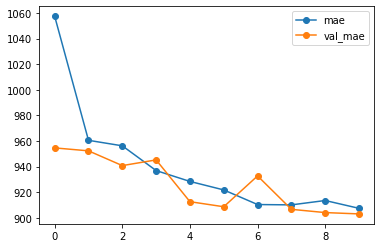

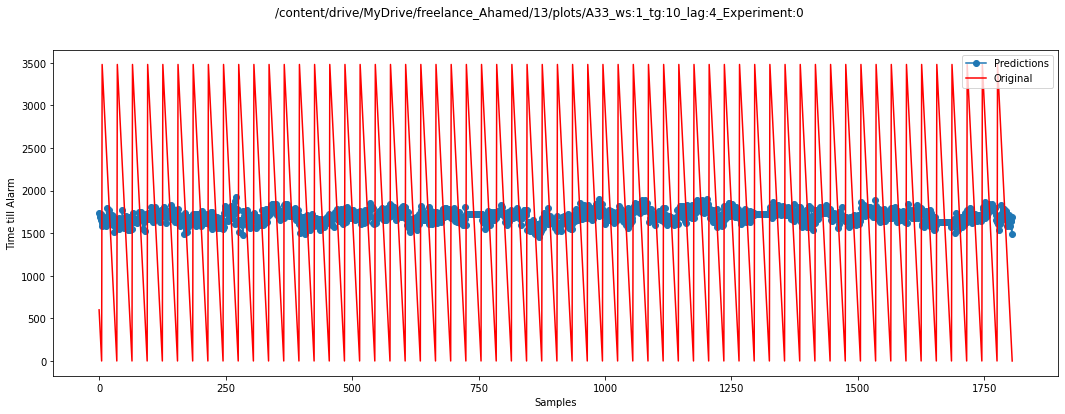

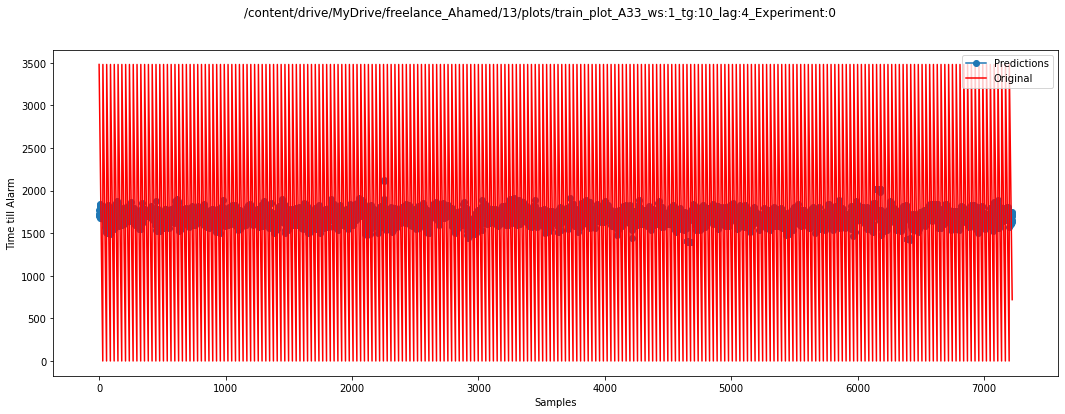

Experiment:  0
330
alarm 1
torch.Size([264, 12, 28, 3])
Epoch 1/10
18/18 [==============================] - 2s 50ms/step - loss: 1772.2457 - mae: 1772.2457 - val_loss: 1607.8695 - val_mae: 1607.8695
Epoch 2/10
18/18 [==============================] - 1s 36ms/step - loss: 1763.3400 - mae: 1763.3400 - val_loss: 1559.6897 - val_mae: 1559.6897
Epoch 3/10
18/18 [==============================] - 1s 36ms/step - loss: 1306.2880 - mae: 1306.2880 - val_loss: 1029.6604 - val_mae: 1029.6604
Epoch 4/10
18/18 [==============================] - 1s 36ms/step - loss: 919.8667 - mae: 919.8667 - val_loss: 971.6985 - val_mae: 971.6985
Epoch 5/10
18/18 [==============================] - 1s 36ms/step - loss: 896.5781 - mae: 896.5781 - val_loss: 953.5059 - val_mae: 953.5059
Epoch 6/10
18/18 [==============================] - 1s 37ms/step - loss: 914.9786 - mae: 914.9786 - val_loss: 962.9990 - val_mae: 962.9990
Epoch 7/10
18/18 [==============================] - 1s 36ms/step - loss: 893.0941 - mae: 893.0941 

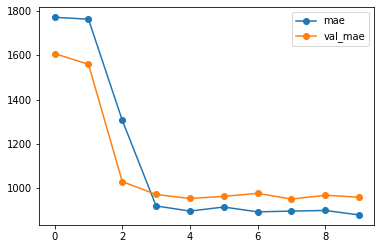

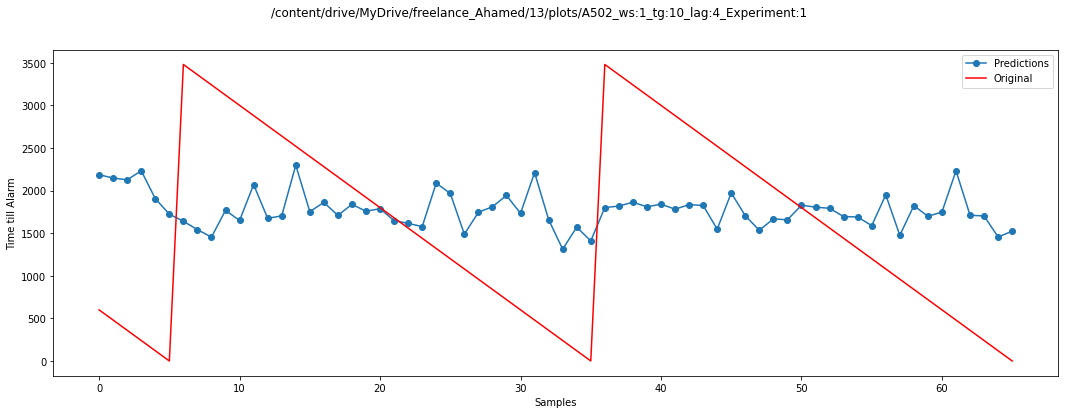

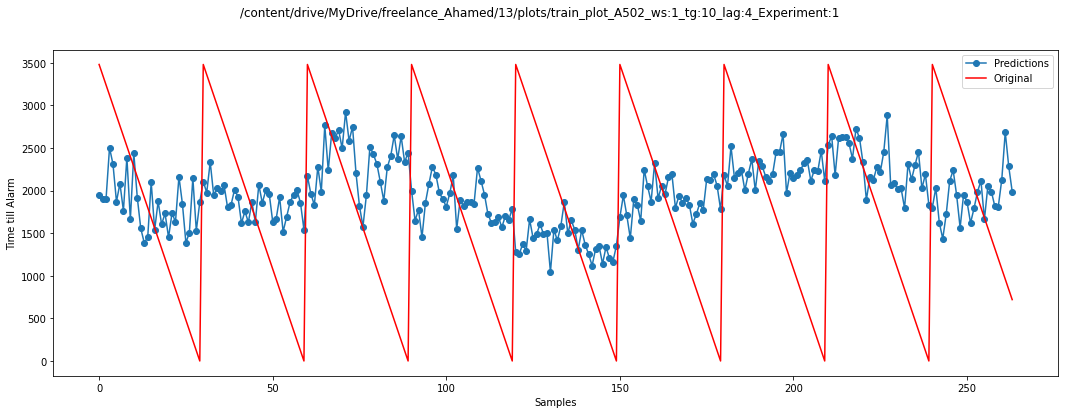

Experiment:  1
9060
alarm 2
torch.Size([7248, 12, 28, 3])
Epoch 1/10
312/484 [==================>...........] - ETA: 6s - loss: 1109.2889 - mae: 1109.2889

KeyboardInterrupt: ignored

In [44]:

cp_components=5
                                 #required for tensor regression

mint=60                          #seconds per minute
minimum_sec=5                    #minimum sampling time in which data was recorded

# Window size in minutes
window = [1,2,3,5,10]       #window size should be between 0.5 minutes to 60 minutes (should be multiple of minimum and maximum tg)

# Time granuality in seconds
tg = [10]             # Time granuality seconds (how many seconds will be averaged)(must be divisible by 5)

lag=[4]   # lag in seconds (2 means lag of time samples)
# for dr in os.listdir(root_dir):
#     path=os.path.join(root_dir,dr)
#     # Perform Tensor regression on the root_dir
#     print(path)
csv_path=hankle_and_train_tensor_regression(root_dir, window=window, tg=tg, lag=lag, cp_components=cp_components,model='nn')
print("Results saved to: ",csv_path)
